# IMPORTS

In [1]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 17kB/s 
     |████████████████████████████████| 51kB 9.4MB/s 
     |████████████████████████████████| 450kB 56.6MB/s 
     |████████████████████████████████| 3.9MB 46.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=d8e24f04232dfbfaa7d77244d388cfb617add99fab70755b7879c2ac3cc3a141
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninsta

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout,Concatenate, Flatten, Activation, BatchNormalization,SpatialDropout1D,Bidirectional,Input, Embedding, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
import re
import ast
from sklearn.datasets import make_classification
from collections import Counter
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.corpus import wordnet
nltk.download('words')
nltk.download('wordnet')
nltk.download('stopwords')
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Preprocessing

In [ ]:
#Loading the cases
path_to_json = '{PATH_TO_CASES_FOLDER}'
dataset= pd.DataFrame()
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

for json_file in json_files:
    json_file=path_to_json+json_file
    with open(json_file) as train_file:
        dict_train = json.load(train_file)
    file_df=pd.DataFrame.from_dict(pd.json_normalize(dict_train), orient='columns')
    dataset=dataset.append(file_df,ignore_index = True)

In [ ]:
#Drop unnessecary columns
dataset.drop(['client_reference','mail_subject','party_id','party_type','unit_id','organization','from_mail','comments'], axis=1, inplace=True) 

In [ ]:
#Text preprocessing
def text_processing(content):
    text_no_html = BeautifulSoup(str(content),"html.parser" ).get_text()
    text_alpha_chars = re.sub("[^a-zA-Z']", " ", str(text_no_html)) 
    text_lower = text_alpha_chars.lower()
    stops = set(stopwords.words('dutch') +stopwords.words('french')+stopwords.words('english'))
    text_no_stop_words = ' '
    for w in text_lower.split():
        if w not in stops:  
            text_no_stop_words = text_no_stop_words + w + ' '

    text_no_short_words=''
    for w in text_no_stop_words.split(): 
        if len(w) >=2:
            text_no_short_words = text_no_short_words + w + ' '

    text_no_eng_words=''
    for w in text_no_short_words.split():
        if w not in words.words():
          if w not in wordnet.words():
            text_no_eng_words = text_no_eng_words + w + ' '

    print(text_no_eng_words)

    return text_no_eng_words
#Get filenames from attachments
def get_fileNames(attachment):
    fileNames=[]
    for obj in attachment:
        fileNames.append(obj['filename'].replace('.pdf', ''))
        fileNamesStr = ' '.join(fileNames)
    return fileNamesStr
#Get content from attachments
def get_content(attachment):
    contents=[]
    for obj in attachment:
        contents.append(obj['content'])
        contentsStr = ' '.join(contents)
        contentsStr=text_processing(contentsStr)
    return contentsStr
    

In [ ]:
dataset['mail_content']=dataset['mail_content'].apply(text_processing)
dataset['attachments_filename']=dataset['attachments'].apply(get_fileNames)
dataset['attachments_content']=dataset['attachments'].apply(get_content)
dataset.drop('attachments', axis=1, inplace=True)

In [6]:
#Only use top 6 of sub_case_type and damage_type
top_amount = 6
list_top_label_sub = list(dataset["labels.sub_case_type"].value_counts()[:top_amount].index.tolist())
print(list_top_label_sub)
dataset = dataset[dataset["labels.sub_case_type"].isin(list_top_label_sub)]
list_top_label_damage = list(dataset["labels.damage_type"].value_counts()[:top_amount].index.tolist())
print(list_top_label_damage)
dataset = dataset[dataset["labels.damage_type"].isin(list_top_label_damage)]

['Fire', 'Operations', 'Familial', '_PrivateClaim', 'Other', 'Auto']
['WaterDamage', 'Other_DamageType', 'Collision', 'Storm', 'Fire_Smoke_Explosion', 'GlassBreakage']


In [7]:
#Create thumbling window for the attachment_content text. Limit of 500 words on LSTM
n=500
dataset=dataset.set_index(['language', 'mail_content','labels.assignment_type','labels.case_type','labels.sub_case_type','labels.damage_type','attachments_filename'])['attachments_content'].str.split().apply(
               lambda x: pd.Series([' '.join(x[i:i+n]) for i in range(0, len(x), n)])
            ).stack().reset_index()
dataset.columns = [*dataset.columns[:-1], 'attachments_content']

In [ ]:
dataset

In [ ]:
#drop level column ex: level_7
dataset=dataset.drop(['level_NUMBER'],axis=1)

In [8]:
#Split targets and features
y=dataset[['labels.case_type','labels.sub_case_type','labels.damage_type','labels.assignment_type']]
X=dataset.drop(['labels.case_type','labels.sub_case_type','labels.damage_type','labels.assignment_type','language'], axis=1)

In [9]:
#Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state=0)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(7328, 3) (7328, 4)
(1833, 3) (1833, 4)


In [10]:
#Safe original test set(for evaluation)
X_test_original=X_test

# Analysis


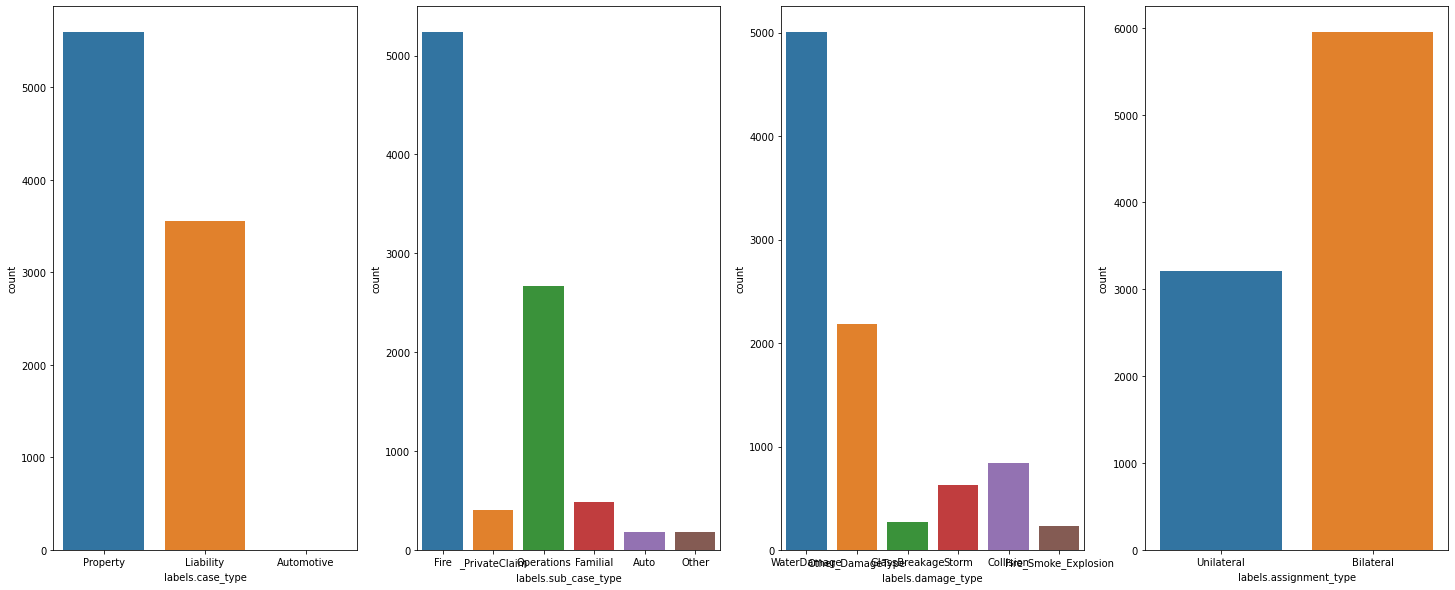

In [ ]:
#Checking unbalancedness
fig, ax = plt.subplots(1,4)
fig.set_figwidth(25)
fig.set_figheight(10)
sns.countplot(x='labels.case_type',data=dataset,ax=ax[0])
sns.countplot(x='labels.sub_case_type',data=dataset,ax=ax[1])
sns.countplot(x='labels.damage_type',data=dataset,ax=ax[2])
sns.countplot(x='labels.assignment_type',data=dataset,ax=ax[3])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

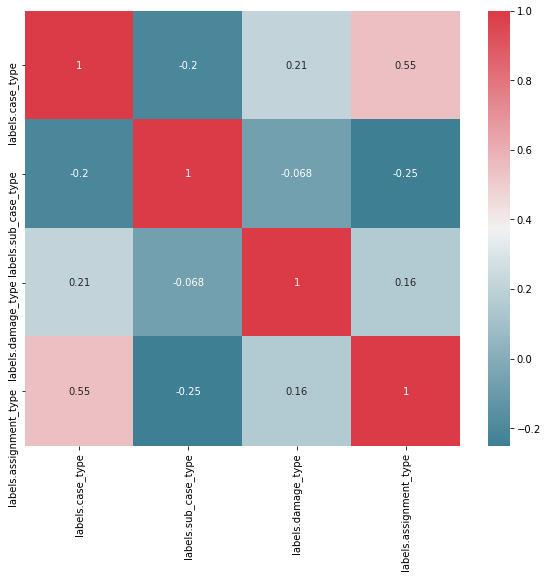

In [ ]:
#Correlation between targets
y_copy=y
y_cat1=pd.Categorical(y_copy['labels.assignment_type'])
y_copy['labels.assignment_type']=y_cat1.codes

y_cat2=pd.Categorical(y_copy['labels.case_type'])
y_copy['labels.case_type']=y_cat2.codes

y_cat3=pd.Categorical(y_copy['labels.sub_case_type'])
y_copy['labels.sub_case_type']=y_cat3.codes

y_cat4=pd.Categorical(y_copy['labels.damage_type'])
y_copy['labels.damage_type']=y_cat4.codes

f, ax = plt.subplots(figsize=(10, 8))
corr = y_copy.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax,annot=True)

# Tokenizer

In [11]:
#Max number of words and embedding dimension
MAX_NB_WORDS = 50000
EMBEDDING_DIM = 100

In [12]:
#mail_content Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X['mail_content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_mc = tokenizer.texts_to_sequences(X_train['mail_content'].values)
X_train_mc = pad_sequences(X_train_mc,maxlen=400)
print('Shape of data X_train_mc:', X_train_mc.shape)

X_test_mc = tokenizer.texts_to_sequences(X_test['mail_content'].values)
X_test_mc = pad_sequences(X_test_mc,maxlen=400)
print('Shape of data X_train_mc:', X_test_mc.shape)

Found 542 unique tokens.
Shape of data X_train_mc: (7328, 400)
Shape of data X_train_mc: (1833, 400)


In [13]:
#attachments_filename Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X['attachments_filename'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_af = tokenizer.texts_to_sequences(X_train['attachments_filename'].values)
X_train_af = pad_sequences(X_train_af,maxlen=200)
print('Shape of data X_train_af:', X_train_af.shape)

X_test_af = tokenizer.texts_to_sequences(X_test['attachments_filename'].values)
X_test_af = pad_sequences(X_test_af,maxlen=200)
print('Shape of data X_test_af:', X_test_af.shape)

Found 14319 unique tokens.
Shape of data X_train_af: (7328, 200)
Shape of data X_test_af: (1833, 200)


In [14]:
#attachments_content Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X['attachments_content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_ac = tokenizer.texts_to_sequences(X_train['attachments_content'].values)
X_train_ac = pad_sequences(X_train_ac,maxlen=500)
print('Shape of data X_train_ac:', X_train_ac.shape)

X_test_ac = tokenizer.texts_to_sequences(X_test['attachments_content'].values)
X_test_ac = pad_sequences(X_test_ac,maxlen=500)
print('Shape of data X_train_ac:', X_test_ac.shape)

Found 41564 unique tokens.
Shape of data X_train_ac: (7328, 500)
Shape of data X_train_ac: (1833, 500)


In [15]:
#Categorical
#assignment_type
train_assignment_cats=pd.Categorical(y_train['labels.assignment_type'])
test_assignment_cats=pd.Categorical(y_test['labels.assignment_type'])
y1_train=train_assignment_cats.codes
y1_test=test_assignment_cats.codes

#case_type
train_case_cats=pd.Categorical(y_train['labels.case_type'])
test_case_cats=pd.Categorical(y_test['labels.case_type'])
y2_train=train_case_cats.codes
y2_test=test_case_cats.codes

#sub_case_type
train_sub_case_cats=pd.Categorical(y_train['labels.sub_case_type'])
test_sub_case_cats=pd.Categorical(y_test['labels.sub_case_type'])
y3_train=train_sub_case_cats.codes
y3_test=test_sub_case_cats.codes

#damage_type
train_damage_cats=pd.Categorical(y_train['labels.damage_type'])
test_damage_cats=pd.Categorical(y_test['labels.damage_type'])
y4_train=train_damage_cats.codes
y4_test=test_damage_cats.codes

print('Shape of label tensor Y1 Train:', y1_train.shape)
print('Shape of label tensor Y1 Test:', y1_test.shape)
print('Shape of label tensor Y2 Train:', y2_train.shape)
print('Shape of label tensor Y2 Test:', y2_test.shape)
print('Shape of label tensor Y3 Train:', y3_train.shape)
print('Shape of label tensor Y3 Test:', y3_test.shape)
print('Shape of label tensor Y4 Train:', y4_train.shape)
print('Shape of label tensor Y4 Test:', y4_test.shape)

Shape of label tensor Y1 Train: (7328,)
Shape of label tensor Y1 Test: (1833,)
Shape of label tensor Y2 Train: (7328,)
Shape of label tensor Y2 Test: (1833,)
Shape of label tensor Y3 Train: (7328,)
Shape of label tensor Y3 Test: (1833,)
Shape of label tensor Y4 Train: (7328,)
Shape of label tensor Y4 Test: (1833,)


# Model

In [16]:
#unbalanced -> calculate balance weights
class_weights_assignment = dict(zip(np.unique(y1_train), class_weight.compute_class_weight('balanced',np.unique(y1_train),np.ravel(y1_train))))
class_weights_damage_type = dict(zip(np.unique(y4_train), class_weight.compute_class_weight('balanced', np.unique(y4_train), np.ravel(y4_train)))) 
adam = tf.keras.optimizers.Adam(learning_rate=0.00001)
# Model checkpoint
checkpoint_filepath = '{PATH_TO_MODEL_CHECKPOINT}'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,save_weights_only=True, monitor='val_loss',mode='auto',save_best_only=True)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience = 35)
# model base
input_mc = Input(shape=(400))
input_af = Input(shape=(200))
input_ac = Input(shape=(500))
model = Sequential()

embeding_mc=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_mc.shape[1])(input_mc)
embeding_af=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_af.shape[1])(input_af)
embeding_ac=Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X_train_ac.shape[1])(input_ac)

#Model1
s_mc_1=SpatialDropout1D(0.5)(embeding_mc)
o_mc_1=LSTM(32, dropout=0.4)(s_mc_1)
s_af_1=SpatialDropout1D(0.5)(embeding_af)
o_af_1=LSTM(32, dropout=0.4)(s_af_1)
s_ac_1=SpatialDropout1D(0.5)(embeding_ac)
o_ac_1=LSTM(32, dropout=0.4)(s_ac_1)

concat_layer_1 = Concatenate()([o_mc_1, o_af_1,o_ac_1])

r_1=Dense(16, activation='relu')(concat_layer_1)
r1_1=Dense(8, activation='relu')(r_1)
r2_1=Dense(4, activation='relu')(r1_1)

lstm_1 = Dense(2, activation='softmax',name='assignment_type')(r2_1)

#Model2
s_mc_2=SpatialDropout1D(0.4)(embeding_mc)
o_mc_2=LSTM(64, dropout=0.4)(s_mc_2)
s_af_2=SpatialDropout1D(0.4)(embeding_af)
o_af_2=LSTM(64, dropout=0.4)(s_af_2)
s_ac_2=SpatialDropout1D(0.4)(embeding_ac)
o_ac_2=LSTM(64, dropout=0.4)(s_ac_2)

concat_layer_2 = Concatenate()([o_mc_2, o_af_2,o_ac_2])

r_2=Dense(32, activation='relu')(concat_layer_2)
r1_2=Dense(16, activation='relu')(r_2)
r2_2=Dense(8, activation ='relu')(r1_2)
r3_2=Dense(4, activation='relu')(r2_2)

lstm_2 = Dense(3, activation='softmax',name='case_type')(r3_2)

#Model3
s_mc_3=SpatialDropout1D(0.4)(embeding_mc)
o_mc_3=LSTM(32, dropout=0.4)(s_mc_3)
s_af_3=SpatialDropout1D(0.4)(embeding_af)
o_af_3=LSTM(32, dropout=0.4)(s_af_3)
s_ac_3=SpatialDropout1D(0.4)(embeding_ac)
o_ac_3=LSTM(32, dropout=0.4)(s_ac_3)

concat_layer_3 = Concatenate()([o_mc_3, o_af_3,o_ac_3])

r_3=Dense(16, activation='relu')(concat_layer_3)
r1_3=Dense(8, activation='relu')(r_3)

lstm_3 = Dense(6, activation='softmax',name='sub_case_type')(r_3)

#Model4
s_mc_4=SpatialDropout1D(0.4)(embeding_mc)
o_mc_4=LSTM(256, dropout=0.4)(s_mc_4)
s_af_4=SpatialDropout1D(0.4)(embeding_af)
o_af_4=LSTM(256, dropout=0.4)(s_af_4)
s_ac_4=SpatialDropout1D(0.4)(embeding_ac)
o_ac_4=LSTM(256, dropout=0.4)(s_ac_4)

concat_layer_4 = Concatenate()([o_mc_4, o_af_4,o_ac_4])

r_4=Dense(128, activation='relu')(concat_layer_4)
r1_4=Dense(64, activation='relu')(r_4)
r2_4=Dense(32, activation='relu')(r1_4)
r3_4=Dense(16, activation='relu')(r2_4)

lstm_4 = Dense(6, activation='softmax',name='damage_type')(r3_4)
########################
model = Model(inputs=[input_mc,input_af,input_ac], outputs=[lstm_1,lstm_2,lstm_3,lstm_4])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model.fit([X_train_mc,X_train_af,X_train_ac], [y1_train,y2_train,y3_train,y4_train], validation_split=0.2,class_weight={'assignment_type':class_weights_assignment,'case_type':{1: 0.8066606840163526, 2: 0.5681977805871611, 0: 2.6666666666665},'sub_case_type':{2: 0.28982755893054896,3: 0.5715177039463423,1: 1.188859878154917,5: 1.9525350593311757,4: 2.196868008948545,0: 2.980392156862745},'damage_type':class_weights_damage_type}, epochs=100,verbose=1,batch_size=64,callbacks=[es,mc])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 100)     5000000     input_1[0][0]                    
______________________________________________________________________________________________

# Evaluation

In [17]:
score = model.evaluate(x=[X_test_mc,X_test_af,X_test_ac], y=[y1_test, y2_test, y3_test, y4_test], verbose=1)
print("Loss:", score[0])
print("Test Accuracy:", score[1])

1833/1833 [==============================] - 7s 4ms/sample - loss: 1.1688 - assignment_type_loss: 0.1870 - case_type_loss: 0.1290 - sub_case_type_loss: 0.3737 - damage_type_loss: 0.4753 - assignment_type_accuracy: 0.9591 - case_type_accuracy: 0.9776 - sub_case_type_accuracy: 0.9416 - damage_type_accuracy: 0.8887
Loss: 1.1688162958888622
Test Accuracy: 0.18700089


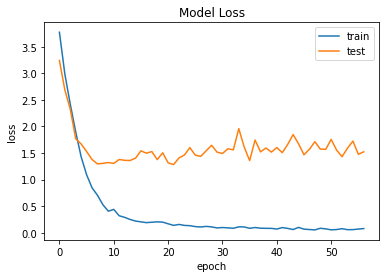

In [18]:
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

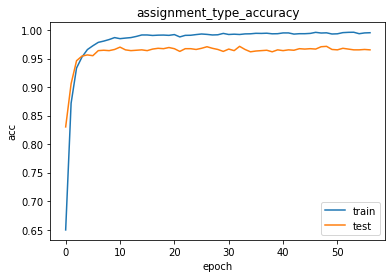

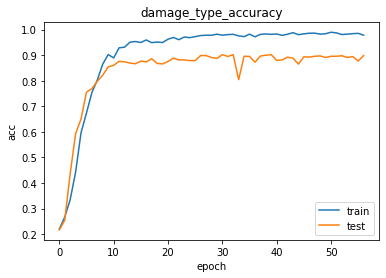

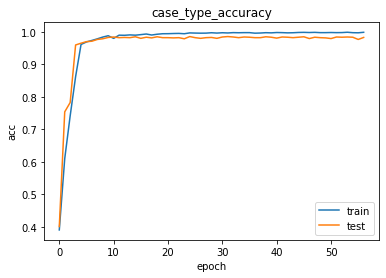

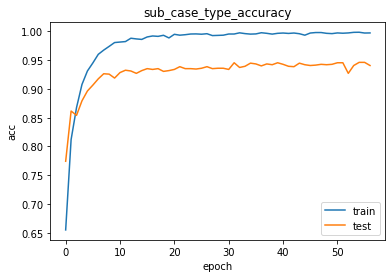

In [19]:
plt.title('assignment_type_accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['assignment_type_accuracy'], label='train')
plt.plot(history.history['val_assignment_type_accuracy'], label='test')
plt.legend()
plt.show();

plt.title('damage_type_accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['damage_type_accuracy'], label='train')
plt.plot(history.history['val_damage_type_accuracy'], label='test')
plt.legend()
plt.show();

plt.title('case_type_accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['case_type_accuracy'], label='train')
plt.plot(history.history['val_case_type_accuracy'], label='test')
plt.legend()
plt.show();

plt.title('sub_case_type_accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.plot(history.history['sub_case_type_accuracy'], label='train')
plt.plot(history.history['val_sub_case_type_accuracy'], label='test')
plt.legend()
plt.show();

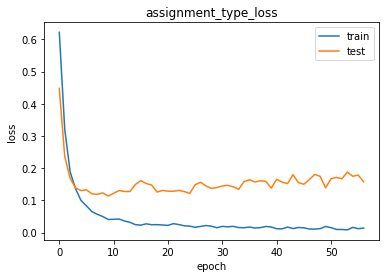

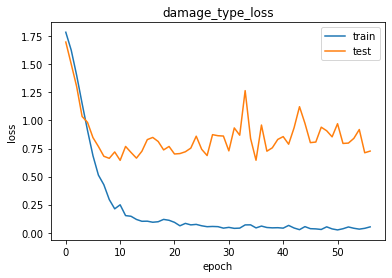

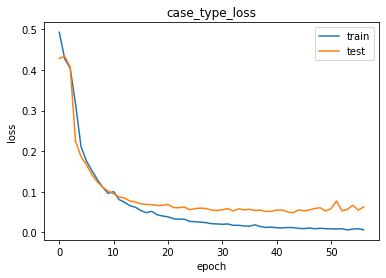

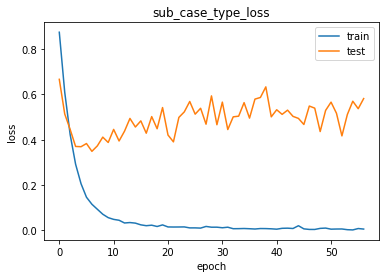

In [20]:
plt.title('assignment_type_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['assignment_type_loss'], label='train')
plt.plot(history.history['val_assignment_type_loss'], label='test')
plt.legend()
plt.show();

plt.title('damage_type_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['damage_type_loss'], label='train')
plt.plot(history.history['val_damage_type_loss'], label='test')
plt.legend()
plt.show();

plt.title('case_type_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['case_type_loss'], label='train')
plt.plot(history.history['val_case_type_loss'], label='test')
plt.legend()
plt.show();

plt.title('sub_case_type_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['sub_case_type_loss'], label='train')
plt.plot(history.history['val_sub_case_type_loss'], label='test')
plt.legend()
plt.show();

# Test precitions

In [22]:
# Testing with the test set
# Loading the the best performing model
# model.load_weights('{PATH_TO_MODEL_CHECKPOINT}')
y1_pred,y2_pred,y3_pred,y4_pred = model.predict([X_test_mc,X_test_af,X_test_ac])

In [23]:
#Predictions to dataframe
predictions_assign=pd.DataFrame(columns=['pred.assignment'],data=test_assignment_cats.categories[np.argmax(y1_pred,axis=1)])
predictions_case=pd.DataFrame(columns=['pred.case'],data=test_case_cats.categories[np.argmax(y2_pred,axis=1)])
predictions_sub_case=pd.DataFrame(columns=['pred.sub_case'],data=test_sub_case_cats.categories[np.argmax(y3_pred,axis=1)])
predictions_damage=pd.DataFrame(columns=['pred.damage'],data=test_damage_cats.categories[np.argmax(y4_pred,axis=1)])
result = pd.concat([X_test_original,predictions_case,predictions_sub_case,predictions_damage,predictions_assign,y_test], axis=1, join="inner")

In [24]:
#Show results
result

,mail_content,attachments_filename,attachments_content,pred.case,pred.sub_case,pred.damage,pred.assignment,labels.case_type,labels.sub_case_type,labels.damage_type,labels.assignment_type
597,bijlage wij document betrekking opdracht toev...,mail makelaar - aangifte waterschade - insijpe...,dirk date subject aangifte schade polis onv be...,Liability,Familial,WaterDamage,Bilateral,Property,Fire,WaterDamage,Unilateral
776,annexe transmettons document concernant missi...,TR Infiltration deau - rue des alliés photo 0...,date november subject tr infiltration rue alli...,Property,Fire,WaterDamage,Bilateral,Property,Fire,WaterDamage,Unilateral
495,sans mevrouw contacteren verzekeraar bijlage ...,Foto's schade plafond Aankoopfactuur vuurkorve...,beperkt herstellen goederen uitsluiting alle k...,Property,_PrivateClaim,Other_DamageType,Bilateral,Property,Fire,WaterDamage,Bilateral
1741,annexe transmettons document concernant missi...,"MISSION_ASSIGNEMENT 2020-0720- ACP Parme, 25- ...",blvd roi ii bic tva rpm entreprise agr nationa...,Property,Fire,WaterDamage,Unilateral,Property,Fire,WaterDamage,Bilateral
747,contactons qualit trouverez annexe document r...,rapport DB 1014063_11-25-2020_32714657 Chiffre...,photos facture honoraires autre db group inter...,Liability,Operations,Other_DamageType,Bilateral,Liability,Operations,Collision,Bilateral
247,sans mevrouw contacteren verzekeraar bijlage ...,FNOL Snapshot IN Schadebestek - Wydisch Josef ...,samenvatting aangifte datum pagina aangifte re...,Property,Fire,WaterDamage,Unilateral,Liability,Operations,GlassBreakage,Bilateral
888,sans contactons qualit trouverez annexe docum...,32708941 sammels sin RC 2021 PV GL C302100877 ...,sinistres num contrat ris num sinistre date su...,Property,Fire,WaterDamage,Bilateral,Property,Other,Other_DamageType,Bilateral
134,annexe transmettons document concernant missi...,version assuré MISSION_ASSIGNEMENT identité d...,use mail virus contamination interception tran...,Liability,Operations,GlassBreakage,Bilateral,Property,Fire,WaterDamage,Unilateral
406,bijlage wij document betrekking opdracht toev...,MISSION_ASSIGNEMENT Vraagt of we expert sturen...,feiten omstandigheden hierbij komen wij terug ...,Liability,Operations,GlassBreakage,Bilateral,Property,Fire,WaterDamage,Bilateral
154,annexe transmettons document concernant missi...,MISSION_ASSIGNEMENT ZSN202013795 déclaration ...,cier partie prime sert couvrir risque assur co...,Property,Fire,Storm,Unilateral,Property,Fire,WaterDamage,Unilateral


# Test Classification Reports

In [25]:
cf = confusion_matrix(test_assignment_cats,test_assignment_cats.categories[np.argmax(y1_pred,axis=1)])
cr= classification_report(test_assignment_cats,test_assignment_cats.categories[np.argmax(y1_pred,axis=1)],target_names=pd.Categorical(test_assignment_cats.categories))
print("assignment_type")
print(cr)
print(cf)

assignment_type
              precision    recall  f1-score   support

   Bilateral       0.98      0.96      0.97      1196
  Unilateral       0.92      0.96      0.94       637

    accuracy                           0.96      1833
   macro avg       0.95      0.96      0.96      1833
weighted avg       0.96      0.96      0.96      1833

[[1146   50]
 [  25  612]]


In [26]:
cf = confusion_matrix(test_case_cats,test_case_cats.categories[np.argmax(y2_pred,axis=1)])
cr= classification_report(test_case_cats,test_case_cats.categories[np.argmax(y2_pred,axis=1)],target_names=pd.Categorical(test_case_cats.categories))
print("case_type")
print(cr)
print(cf)

case_type
              precision    recall  f1-score   support

  Automotive       0.00      0.00      0.00         1
   Liability       0.97      0.98      0.97       683
    Property       0.98      0.98      0.98      1149

    accuracy                           0.98      1833
   macro avg       0.65      0.65      0.65      1833
weighted avg       0.98      0.98      0.98      1833

[[   0    0    1]
 [   0  666   17]
 [   0   23 1126]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
cf = confusion_matrix(test_sub_case_cats,test_sub_case_cats.categories[np.argmax(y3_pred,axis=1)])
cr= classification_report(test_sub_case_cats,test_sub_case_cats.categories[np.argmax(y3_pred,axis=1)],target_names=pd.Categorical(test_sub_case_cats.categories))
print("sub_case_type")
print(cr)
print(cf)

sub_case_type
               precision    recall  f1-score   support

         Auto       0.93      0.90      0.91        29
     Familial       0.82      0.84      0.83        89
         Fire       0.97      0.99      0.98      1071
   Operations       0.94      0.95      0.94       522
        Other       0.60      0.38      0.46        40
_PrivateClaim       0.84      0.72      0.78        82

     accuracy                           0.94      1833
    macro avg       0.85      0.79      0.82      1833
 weighted avg       0.94      0.94      0.94      1833

[[  26    0    2    0    1    0]
 [   0   75    3    7    1    3]
 [   0    0 1056    8    4    3]
 [   0   14   10  495    2    1]
 [   0    3    2   16   15    4]
 [   2    0   18    1    2   59]]


In [28]:
#Categorical
cf = confusion_matrix(test_damage_cats,test_damage_cats.categories[np.argmax(y4_pred,axis=1)])
cr= classification_report(test_damage_cats,test_damage_cats.categories[np.argmax(y4_pred,axis=1)],target_names=pd.Categorical(test_damage_cats.categories))
print("damage_type")
print(cr)
print(cf)

damage_type
                      precision    recall  f1-score   support

           Collision       0.84      0.89      0.87       161
Fire_Smoke_Explosion       0.54      0.74      0.62        53
       GlassBreakage       0.57      0.75      0.65        61
    Other_DamageType       0.91      0.92      0.91       427
               Storm       0.80      0.80      0.80       122
         WaterDamage       0.95      0.90      0.93      1009

            accuracy                           0.89      1833
           macro avg       0.77      0.83      0.80      1833
        weighted avg       0.90      0.89      0.89      1833

[[144   0   4   7   1   5]
 [  3  39   2   2   2   5]
 [  2   0  46   6   1   6]
 [  4   2   8 391   4  18]
 [  0  11   1   2  98  10]
 [ 18  20  20  24  16 911]]
